### Imports

In [2]:
import os
import pandas as pd
import numpy as np
import h2o
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from ai_data_science_team.ml_agents import H2OMLAgent
from collections import defaultdict

### Configurations and loading

In [3]:
# 1.0 LOADING VARIABLES AND GROQ CONFIGURATION
load_dotenv()

# Configure LangChain to communicate with Groq using the OpenAI interface
GROQ_MODEL = "meta-llama/llama-4-scout-17b-16e-instruct" # "openai/gpt-oss-120b"

llm = ChatOpenAI(
    model=GROQ_MODEL,
    openai_api_key=os.getenv("GROQ_API_KEY"),
    openai_api_base="https://api.groq.com/openai/v1" # Redirect calls to Groq
)

llm

ChatOpenAI(profile={}, client=<openai.resources.chat.completions.completions.Completions object at 0x0000027EA9CF2910>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000027EAB5F4A10>, root_client=<openai.OpenAI object at 0x0000027EA9D69C90>, root_async_client=<openai.AsyncOpenAI object at 0x0000027EAB5F4550>, model_name='meta-llama/llama-4-scout-17b-16e-instruct', model_kwargs={}, openai_api_key=SecretStr('**********'), openai_api_base='https://api.groq.com/openai/v1')

In [4]:
# 2.0 PATHS AND DATA
PATH_ROOT = "btc_forecast/"
MODEL_PATH = os.path.join(os.getcwd(), PATH_ROOT, "h2o_models/")
LOG_PATH = os.path.join(os.getcwd(), PATH_ROOT, "ai_logs/")
MODEL_PATH_RETRAINING = os.path.join(os.getcwd(), PATH_ROOT, "h2o_models_retraining/")
LOG_PATH_RETRAINING = os.path.join(os.getcwd(), PATH_ROOT, "ai_logs_retraining/")
DATA_REDUCED_PATH = os.path.join(os.getcwd(), "data/df_reduced.csv")
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(LOG_PATH, exist_ok=True)
os.makedirs(MODEL_PATH_RETRAINING, exist_ok=True)
os.makedirs(LOG_PATH_RETRAINING, exist_ok=True)

df_orig = pd.read_csv("data/all_together/dataset_X_and_y_mfe_log.csv", low_memory=False)
df_orig.set_index("anchor_t", inplace=True)
df_orig.index = pd.to_datetime(df_orig.index)

# --- NEW PREVENTIVE CLEANING ---
# Remove problematic columns
cols_to_drop = ['df_macroeconomic_data__DowJones_Volume_yf'] + [c for c in df_orig.columns if "bitcoin_data" in c]
df = df_orig.drop(columns=[c for c in cols_to_drop if c in df_orig.columns])

# FORCE EVERYTHING TO NUMERIC: This avoids NullPointerException in H2O
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 1. Infinite Management: Replace Inf with NaN
df = df.replace([np.inf, -np.inf], np.nan)
# 2. Remove columns with too many missing values (e.g., over 50% NaN)
# This greatly helps GLM stability
threshold = len(df) * 0.5
df = df.dropna(thresh=threshold, axis=1)
# 3. Drop identical columns
duplicates_map = {}
for col in df.columns:
    # Use tuple of values as key to identify identical columns
    vals = tuple(df[col])
    if vals not in duplicates_map:
        duplicates_map[vals] = []
    duplicates_map[vals].append(col)

# 4. ffill and remove initial NaNs
df = df.ffill()
df = df.dropna()

assert (df.index.max() - df.index.min()).days + 1 == len(df), "Index is not continuous"

cols_to_keep = []
for names in duplicates_map.values():
    # Priority: keep 'bgeometrics' if present, then 'bitcoin_data', else the first one
    bgeo = [n for n in names if "bgeometrics" in n]
    bdata = [n for n in names if "bitcoin_data" in n]
    if bgeo:
        cols_to_keep.append(bgeo[0])
    elif bdata:
        cols_to_keep.append(bdata[0])
    else:
        cols_to_keep.append(names[0])

# Drop duplicate columns
df = df[cols_to_keep]

print("\n--- CLEANING SUMMARY ---")
print(f"Original shape: {df_orig.shape}")
print(f"Duplicate columns dropped: {len(duplicates_map) - len(cols_to_keep)}")
print(f"Final shape: {df.shape}")

df


--- CLEANING SUMMARY ---
Original shape: (2081, 498)
Duplicate columns dropped: 0
Final shape: (1213, 227)


,entry_price,df_bgeometrics__moving_average_price,df_bgeometrics__short_term_trends_average,df_bgeometrics__10dma,df_bgeometrics__20dma,df_bgeometrics__short_term_trends_7sma,df_bgeometrics__40dma,df_bgeometrics__50dma,df_bgeometrics__155dma,df_bgeometrics__200dma,...,df_macroeconomic_data__S&P500_high_yf,df_macroeconomic_data__S&P500_low_yf,df_macroeconomic_data__S&P500_open_yf,df_macroeconomic_data__S&P500_volume_yf,df_macroeconomic_data__VIX_Close_yf,df_macroeconomic_data__VIX_High_yf,df_macroeconomic_data__VIX_Low_yf,df_macroeconomic_data__VIX_Open_yf,df_open_interest_BTCUSDT_Bybit__bybit_open_interest,y_mfe_log
anchor_t,,,,,,,,,,,,,,,,,,,,,
2022-08-10 11:00:00+00:00,24466.0,23923.058483,43.75,23262.710743,23041.505577,45.092857,21964.460682,21692.586724,31293.643923,33242.866533,...,4211.029785,4177.259766,4181.020020,4.546010e+09,19.740000,22.340000,19.540001,22.280001,47001313.0,-0.032506
2022-08-11 11:00:00+00:00,23741.0,23934.439056,56.25,23323.010379,23102.923352,47.324286,22079.275080,21757.506202,31198.217870,33187.556774,...,4257.910156,4201.410156,4227.399902,4.630200e+09,20.200001,20.850000,19.709999,19.840000,40009223.0,0.046338
2022-08-12 11:00:00+00:00,24482.5,24396.308846,43.75,23459.498575,23198.515833,47.770000,22208.387008,21845.369013,31084.714038,33128.183067,...,4280.470215,4219.779785,4225.020020,3.788010e+09,19.530001,20.350000,19.120001,20.340000,42131553.0,0.022156
2022-08-13 11:00:00+00:00,24605.0,24426.222575,56.25,23569.720832,23287.159110,48.215714,22337.129706,21911.951407,30987.578322,33067.015553,...,4280.470215,4219.779785,4225.020020,3.788010e+09,19.530001,20.350000,19.120001,20.340000,41094917.0,-0.030662
2022-08-14 11:00:00+00:00,24256.0,24314.202132,56.25,23738.307837,23427.362937,50.447143,22439.327297,21972.253910,30893.957920,33003.823630,...,4280.470215,4219.779785,4225.020020,3.788010e+09,19.530001,20.350000,19.120001,20.340000,43853888.0,-0.020661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-30 11:00:00+00:00,86601.0,90607.702151,46.43,88663.303528,91926.537334,54.591429,99955.841100,102057.213868,110793.490822,109733.692120,...,5627.560059,5488.729980,5527.910156,5.257250e+09,22.280001,24.799999,21.670000,24.110001,70920849.0,-0.033412
2025-12-01 11:00:00+00:00,87237.4,86504.636816,46.43,88818.962578,91103.048894,53.571429,99426.766266,101484.248264,110652.482661,109647.633884,...,5627.560059,5488.729980,5527.910156,5.257250e+09,22.280001,24.799999,21.670000,24.110001,70920849.0,0.073928
2025-12-02 11:00:00+00:00,92903.9,91528.024581,46.43,89494.264881,90595.343791,52.551429,98963.443460,101008.163697,110551.675716,109587.442661,...,5627.560059,5488.729980,5527.910156,5.257250e+09,22.280001,24.799999,21.670000,24.110001,70920849.0,0.013742


### Feature engineering OHLCV data + join

In [5]:
ohlcv_1m = pd.read_csv("data/raw/bitcoin_bybit_futures_USDT_25_03_2020_10_36_00_07_12_2025_00_00_00_timeframe_1m.csv", index_col="timestamp", parse_dates=True)
ohlcv_1m

,open_bybit_futures,high_bybit_futures,low_bybit_futures,close_bybit_futures,volume_bybit_futures
timestamp,,,,,
2020-03-25 10:36:00+00:00,6500.0,6500.0,6500.0,6500.0,0.001
2020-03-25 10:37:00+00:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:38:00+00:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:39:00+00:00,6500.0,6500.0,6500.0,6500.0,0.000
2020-03-25 10:40:00+00:00,6500.0,6500.0,6500.0,6500.0,0.000
...,...,...,...,...,...
2025-12-06 23:56:00+00:00,89180.0,89211.3,89179.9,89211.2,24.816
2025-12-06 23:57:00+00:00,89211.2,89211.9,89203.3,89203.4,5.892
2025-12-06 23:58:00+00:00,89203.4,89203.4,89194.4,89199.0,9.788


In [6]:
"_".join(map(str, (2,)))

'2'

In [7]:
class Operator:
    """
    Class to define an operator and apply it sparsely over a large time-series.
    """
    def __init__(self, name, func, params_list=None):
        self.name = name
        self.func = func
        # If no params provided, use a list with an empty tuple to trigger one execution
        self.params_list = params_list #if params_list is not None else [()]

    def apply_sparse(self, full_series, col_name, target_indices, pos_map):
        """
        Applies the operator logic only to specific timestamps (target_indices).
        For each parameter set, it slices the required history to satisfy lookback requirements.
        """
        features = {}
        safety_buffer = 10 # Buffer to ensure stability for warm-up

        for params in self.params_list:
            # Ensure params is a tuple for unpacking/processing
            args = params if isinstance(params, (tuple, list)) else (params,)
            
            # 1. GENERATE FEATURE NAME: {name}_{p1}_{p2}_..._{pn}({col})
            param_suffix = "_".join(map(str, args))
            feat_name = f"{self.name}_{param_suffix}({col_name})"
            
            # 2. DYNAMIC LOOKBACK CALCULATION
            # We use the first parameter as the lookback reference (window, lag, or diff order)
            lookback_val = args[0] #if (args and isinstance(args[0], (int, float))) else 1
            
            # For "diff", the lookback needed is just the order n. 
            # For "lag", the lookback is the lag l.
            # For rolling windows, it is the window size w.
            total_lookback = int(lookback_val) + safety_buffer
            
            # 3. SELECTIVE CALCULATION
            feat_values = []
            for idx in target_indices:
                if idx not in pos_map:
                    feat_values.append(np.nan)
                    continue
                
                # Identify the integer position and calculate the required slice
                curr_pos = pos_map[idx]
                start_pos = max(0, curr_pos - total_lookback)
                
                # Slice the history only for the required window
                subset = full_series.iloc[start_pos : curr_pos + 1]
                
                try:
                    # Apply the core logic to the sliced subset
                    res = self.func(subset, *args)
                    # Extract the last resulting value
                    val = res.iloc[-1] if hasattr(res, 'iloc') else res
                    feat_values.append(val)
                except Exception:
                    feat_values.append(np.nan)
            
            features[feat_name] = feat_values
            
        return features

# --- TECHNICAL INDICATOR FUNCTIONS ---

def diff_calc(series, n):
    """Calculates the derivative of order n by applying diff() n times."""
    for _ in range(n):
        series = series.diff()
    return series

def rsi_calc(series, window):
    """Relative Strength Index."""
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / (loss + 1e-9)
    return 100 - (100 / (1 + rs))

def bb_upper(series, window, std_coef):
    """Bollinger Band Upper."""
    return series.rolling(window=window).mean() + (std_coef * series.rolling(window=window).std())

def bb_lower(series, window, std_coef):
    """Bollinger Band Lower."""
    return series.rolling(window=window).mean() - (std_coef * series.rolling(window=window).std())


# --- CONFIGURATION ---

windows = [10, 60, 360, 720, 1440, 1440*2, 1440*3]
lags = [10, 60, 360]
diff_orders = [1, 2] # Orders of the derivative
# first param of BB must be the window to stay consistent with args[0] in lookback calculation
bb_params = [(w, std_coef) for w in windows for std_coef in [1, 2]]

operators = [
    Operator("diff", diff_calc, diff_orders), # Now generalized with orders 1 and 2
    Operator("mean", lambda s, w: s.rolling(w).mean(), windows),
    Operator("median", lambda s, w: s.rolling(w).median(), windows),
    Operator("stdev", lambda s, w: s.rolling(w).std(), windows),
    Operator("RSI", rsi_calc, windows),
    Operator("lag", lambda s, l: s.shift(l), lags),
    Operator("BB_upper", bb_upper, bb_params),
    Operator("BB_lower", bb_lower, bb_params),
]

# adding suffix to operator names to identify the timeframe of the dataset used
for op in operators:
    op.name = op.name + '_1m'

def engineer_features_sparse(target_df, source_df, operators):
    """
    Optimized feature engineering that computes indicators only for sparse target timestamps.
    It uses lookback data from source_df to satisfy historical calculations.
    """
    # Map index timestamps to integer positions for O(1) lookups
    pos_map = {val: i for i, val in enumerate(source_df.index)}
    target_indices = target_df.index
    
    new_features_dict = {}

    for col in source_df.columns:
        print(f"Applying operators to '{col}'...")
        full_series = source_df[col]
        
        for op in operators:
            # Result: {feat_name_with_col: values_list}
            sparse_results = op.apply_sparse(full_series, col, target_indices, pos_map)
            new_features_dict.update(sparse_results)
    
    # Create the feature dataframe and join
    features_df = pd.DataFrame(new_features_dict, index=target_indices)
    return pd.concat([target_df, features_df], axis=1)

# --- EXECUTION ---
# 'df' contains the target timestamps, 'ohlcv_1m' contains the full history
df = engineer_features_sparse(df, ohlcv_1m, operators)
print("Feature Engineering completed successfully.")
df

Applying operators to 'open_bybit_futures'...
Applying operators to 'high_bybit_futures'...
Applying operators to 'low_bybit_futures'...
Applying operators to 'close_bybit_futures'...
Applying operators to 'volume_bybit_futures'...
Feature Engineering completed successfully.


,entry_price,df_bgeometrics__moving_average_price,df_bgeometrics__short_term_trends_average,df_bgeometrics__10dma,df_bgeometrics__20dma,df_bgeometrics__short_term_trends_7sma,df_bgeometrics__40dma,df_bgeometrics__50dma,df_bgeometrics__155dma,df_bgeometrics__200dma,...,BB_lower_1m_360_1(volume_bybit_futures),BB_lower_1m_360_2(volume_bybit_futures),BB_lower_1m_720_1(volume_bybit_futures),BB_lower_1m_720_2(volume_bybit_futures),BB_lower_1m_1440_1(volume_bybit_futures),BB_lower_1m_1440_2(volume_bybit_futures),BB_lower_1m_2880_1(volume_bybit_futures),BB_lower_1m_2880_2(volume_bybit_futures),BB_lower_1m_4320_1(volume_bybit_futures),BB_lower_1m_4320_2(volume_bybit_futures)
anchor_t,,,,,,,,,,,,,,,,,,,,,
2022-08-10 11:00:00+00:00,24466.0,23923.058483,43.75,23262.710743,23041.505577,45.092857,21964.460682,21692.586724,31293.643923,33242.866533,...,-4.762679,-65.315128,-179.552884,-433.812804,-144.131886,-380.649329,-102.050119,-294.963453,-94.144789,-277.323247
2022-08-11 11:00:00+00:00,23741.0,23934.439056,56.25,23323.010379,23102.923352,47.324286,22079.275080,21757.506202,31198.217870,33187.556774,...,-26.170971,-173.790894,-69.580235,-264.117152,-220.824403,-612.004559,-194.152436,-519.675526,-160.480492,-438.321713
2022-08-12 11:00:00+00:00,24482.5,24396.308846,43.75,23459.498575,23198.515833,47.770000,22208.387008,21845.369013,31084.714038,33128.183067,...,-54.797914,-190.367635,-35.895411,-152.492796,-106.272141,-334.685930,-174.910297,-496.069295,-168.416272,-465.126864
2022-08-13 11:00:00+00:00,24605.0,24426.222575,56.25,23569.720832,23287.159110,48.215714,22337.129706,21911.951407,30987.578322,33067.015553,...,-13.472518,-132.637156,-24.961784,-157.355775,-62.339641,-228.250437,-86.948578,-286.753558,-147.852417,-427.727685
2022-08-14 11:00:00+00:00,24256.0,24314.202132,56.25,23738.307837,23427.362937,50.447143,22439.327297,21972.253910,30893.957920,33003.823630,...,-102.748825,-337.793467,-83.473596,-259.978400,-59.165889,-192.459677,-62.331651,-213.512828,-81.339232,-262.625365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-30 11:00:00+00:00,86601.0,90607.702151,46.43,88663.303528,91926.537334,54.591429,99955.841100,102057.213868,110793.490822,109733.692120,...,-24.585444,-71.446655,-19.683956,-56.160221,-21.748723,-64.065703,-38.143016,-109.089011,-29.890636,-92.929805
2025-12-01 11:00:00+00:00,87237.4,86504.636816,46.43,88818.962578,91103.048894,53.571429,99426.766266,101484.248264,110652.482661,109647.633884,...,6.248421,-28.242102,-62.197888,-210.107507,-58.513197,-172.304736,-49.645890,-137.215080,-47.918726,-136.132218
2025-12-02 11:00:00+00:00,92903.9,91528.024581,46.43,89494.264881,90595.343791,52.551429,98963.443460,101008.163697,110551.675716,109587.442661,...,-32.481092,-105.548754,-31.334843,-107.968969,-36.074322,-151.792394,-47.923046,-163.307138,-47.969830,-147.769776


In [8]:
# I'll also concatenate the original ohlcv_1m columns using only df indexes
df = df.join(ohlcv_1m)
df

,entry_price,df_bgeometrics__moving_average_price,df_bgeometrics__short_term_trends_average,df_bgeometrics__10dma,df_bgeometrics__20dma,df_bgeometrics__short_term_trends_7sma,df_bgeometrics__40dma,df_bgeometrics__50dma,df_bgeometrics__155dma,df_bgeometrics__200dma,...,BB_lower_1m_1440_2(volume_bybit_futures),BB_lower_1m_2880_1(volume_bybit_futures),BB_lower_1m_2880_2(volume_bybit_futures),BB_lower_1m_4320_1(volume_bybit_futures),BB_lower_1m_4320_2(volume_bybit_futures),open_bybit_futures,high_bybit_futures,low_bybit_futures,close_bybit_futures,volume_bybit_futures
anchor_t,,,,,,,,,,,,,,,,,,,,,
2022-08-10 11:00:00+00:00,24466.0,23923.058483,43.75,23262.710743,23041.505577,45.092857,21964.460682,21692.586724,31293.643923,33242.866533,...,-380.649329,-102.050119,-294.963453,-94.144789,-277.323247,23052.5,23061.0,23050.0,23050.0,30.906
2022-08-11 11:00:00+00:00,23741.0,23934.439056,56.25,23323.010379,23102.923352,47.324286,22079.275080,21757.506202,31198.217870,33187.556774,...,-612.004559,-194.152436,-519.675526,-160.480492,-438.321713,24466.0,24466.0,24455.0,24460.0,25.634
2022-08-12 11:00:00+00:00,24482.5,24396.308846,43.75,23459.498575,23198.515833,47.770000,22208.387008,21845.369013,31084.714038,33128.183067,...,-334.685930,-174.910297,-496.069295,-168.416272,-465.126864,23741.0,23754.5,23727.5,23754.5,310.909
2022-08-13 11:00:00+00:00,24605.0,24426.222575,56.25,23569.720832,23287.159110,48.215714,22337.129706,21911.951407,30987.578322,33067.015553,...,-228.250437,-86.948578,-286.753558,-147.852417,-427.727685,24482.5,24484.0,24482.0,24484.0,14.701
2022-08-14 11:00:00+00:00,24256.0,24314.202132,56.25,23738.307837,23427.362937,50.447143,22439.327297,21972.253910,30893.957920,33003.823630,...,-192.459677,-62.331651,-213.512828,-81.339232,-262.625365,24605.0,24605.5,24605.0,24605.5,46.761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-30 11:00:00+00:00,86601.0,90607.702151,46.43,88663.303528,91926.537334,54.591429,99955.841100,102057.213868,110793.490822,109733.692120,...,-64.065703,-38.143016,-109.089011,-29.890636,-92.929805,91188.0,91207.7,91175.0,91175.0,8.812
2025-12-01 11:00:00+00:00,87237.4,86504.636816,46.43,88818.962578,91103.048894,53.571429,99426.766266,101484.248264,110652.482661,109647.633884,...,-172.304736,-49.645890,-137.215080,-47.918726,-136.132218,86601.0,86614.7,86601.0,86601.1,9.427
2025-12-02 11:00:00+00:00,92903.9,91528.024581,46.43,89494.264881,90595.343791,52.551429,98963.443460,101008.163697,110551.675716,109587.442661,...,-151.792394,-47.923046,-163.307138,-47.969830,-147.769776,87237.4,87279.3,87218.0,87262.4,39.117


In [9]:
assert df.isna().sum().sum() == 0

### Feature engineering all data

In [11]:
# --- CONFIGURATION ---
windows = [7, 15, 30]
lags = [1, 2, 3]
# first param of BB must be the window to stay consistent with args[0] in lookback calculation
bb_params = [(w, std_coef) for w in windows for std_coef in [1, 2]]

diff_orders = [1, 2] # Orders of the derivative


operators = [
    Operator("diff", diff_calc, diff_orders), # Now generalized with orders 1 and 2
    Operator("mean", lambda s, w: s.rolling(w).mean(), windows),
    Operator("median", lambda s, w: s.rolling(w).median(), windows),
    Operator("stdev", lambda s, w: s.rolling(w).std(), windows),
    Operator("RSI", rsi_calc, windows),
    Operator("lag", lambda s, l: s.shift(l), lags),
    Operator("BB_upper", bb_upper, bb_params),
    Operator("BB_lower", bb_lower, bb_params),
]

# adding suffix to operator names to identify the timeframe of the dataset used
for op in operators:
    op.name = op.name + '_1d'

def engineer_features(df, operators):
    """
    Applies feature engineering operators to all columns of the dataframe.
    """
    new_features_dict = {}

    for col in df.columns:
        series = df[col]
        for op in operators:
            for p in op.params_list:
                p_suffix = "_".join(map(str, p)) if isinstance(p, (list, tuple)) else str(p)
                feat_name = f"{op.name}_{p_suffix}({col})"
                
                if isinstance(p, (list, tuple)):
                    new_features_dict[feat_name] = op.func(series, *p)
                else:
                    new_features_dict[feat_name] = op.func(series, p)
    
    features_df = pd.DataFrame(new_features_dict, index=df.index)
    return pd.concat([df, features_df], axis=1)

# --- EXECUTION ---
df = engineer_features(df, operators).dropna()
print("Feature Engineering completed successfully.")
df

Feature Engineering completed successfully.


,entry_price,df_bgeometrics__moving_average_price,df_bgeometrics__short_term_trends_average,df_bgeometrics__10dma,df_bgeometrics__20dma,df_bgeometrics__short_term_trends_7sma,df_bgeometrics__40dma,df_bgeometrics__50dma,df_bgeometrics__155dma,df_bgeometrics__200dma,...,BB_upper_1d_15_1(volume_bybit_futures),BB_upper_1d_15_2(volume_bybit_futures),BB_upper_1d_30_1(volume_bybit_futures),BB_upper_1d_30_2(volume_bybit_futures),BB_lower_1d_7_1(volume_bybit_futures),BB_lower_1d_7_2(volume_bybit_futures),BB_lower_1d_15_1(volume_bybit_futures),BB_lower_1d_15_2(volume_bybit_futures),BB_lower_1d_30_1(volume_bybit_futures),BB_lower_1d_30_2(volume_bybit_futures)
anchor_t,,,,,,,,,,,,,,,,,,,,,
2022-09-08 11:00:00+00:00,21061.5,19319.124851,37.50,19692.617858,20285.494925,41.071429,21854.535248,22043.613023,27241.178680,30516.149080,...,112.950822,158.190445,147.890165,216.549096,15.049444,-38.452397,22.471578,-22.768045,10.572302,-58.086629
2022-09-09 11:00:00+00:00,21331.0,21363.189449,37.50,19846.390482,20296.321657,41.071429,21804.710679,22007.828625,27099.619017,30430.206915,...,115.404862,161.976391,151.032856,219.613245,16.509220,-41.345846,22.261805,-24.309724,13.872077,-54.708312
2022-09-10 11:00:00+00:00,21580.0,21715.597252,50.00,20015.483047,20304.401711,42.857143,21764.314543,21988.018899,26958.629017,30353.294721,...,114.192422,163.577178,151.032939,220.290045,8.561700,-53.347885,15.422911,-33.961845,12.518727,-56.738379
2022-09-11 11:00:00+00:00,22144.5,21732.864358,53.13,20178.223222,20325.990726,45.090000,21731.850480,21972.987002,26826.440601,30270.946073,...,118.281117,169.561967,130.320600,185.129900,17.916440,-45.694406,15.719417,-35.561433,20.702000,-34.107300
2022-09-12 11:00:00+00:00,22520.5,22364.723580,40.63,20419.809905,20367.501187,42.858571,21707.868569,21967.214333,26695.367883,30196.228347,...,119.214999,168.186065,130.701899,184.394699,16.707326,-31.529633,21.272867,-27.698199,23.316301,-30.376499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-30 11:00:00+00:00,86601.0,90607.702151,46.43,88663.303528,91926.537334,54.591429,99955.841100,102057.213868,110793.490822,109733.692120,...,48.338708,67.446282,80.483444,126.347855,11.472365,-4.459126,10.123559,-8.984016,-11.245377,-57.109788
2025-12-01 11:00:00+00:00,87237.4,86504.636816,46.43,88818.962578,91103.048894,53.571429,99426.766266,101484.248264,110652.482661,109647.633884,...,48.332450,67.386766,80.277423,126.303079,6.907427,-9.689146,10.223817,-8.830500,-11.773890,-57.799546
2025-12-02 11:00:00+00:00,92903.9,91528.024581,46.43,89494.264881,90595.343791,52.551429,98963.443460,101008.163697,110551.675716,109587.442661,...,49.425950,68.588300,80.397300,126.430832,7.537321,-7.221357,11.101250,-8.061100,-11.669766,-57.703299


In [12]:
assert (df.index.max() - df.index.min()).days + 1 == len(df), "Index of df is not a contiguous range"

In [ ]:
def find_duplicate_column_groups(df: pd.DataFrame):
    """
    Returns a list of lists: each sublist contains identical columns.
    If a group contains both "bgeomtrics" and "bitcoin_data" columns, only the columns with "bgeometrics" are kept.
    """
    sig2cols = defaultdict(list)

    # 1) Group by fast hash
    for col in df.columns:
        sig = pd.util.hash_pandas_object(df[col], index=False).sum()
        sig2cols[sig].append(col)

    # 2) Verify hash collisions and filter according to the bgeometrics/bitcoin_data rule
    groups = []
    for cols in sig2cols.values():
        if len(cols) < 2:
            continue
        base = cols[0]
        equal_set = [base]
        for c in cols[1:]:
            if df[base].equals(df[c]):
                equal_set.append(c)
        if len(equal_set) > 1:
            # If the group contains both bgeometrics and bitcoin_data, keep only bgeometrics
            has_bgeometrics = any('bgeometrics' in col for col in equal_set)
            has_bitcoin_data = any('bitcoin_data' in col for col in equal_set)
            if has_bgeometrics and has_bitcoin_data:
                equal_set = [col for col in equal_set if 'bgeometrics' in col]
            groups.append(equal_set)
    return groups

dup_groups = find_duplicate_column_groups(df)

if not dup_groups:
    print("✅ No duplicate columns found.")
else:
    print("🔁 Identical column groups:")
    for i, g in enumerate(dup_groups, 1):
        print(f"\nSet {i} ({len(g)} columns): {g}")
        for c in g:
            print(f"  {c}: {df[c].head().tolist()}")

    # drop duplicates keeping the first column of each set
    to_drop = [c for g in dup_groups for c in g[1:]]
    df = df.drop(columns=to_drop)
    print(f"\n✅ Removed {len(to_drop)} duplicate columns. Remaining: {df.shape[1]}")

df

🔁 Identical column groups:

Set 1 (3 columns): ['df_bgeometrics__moving_average_price', 'df_bgeometrics__pi_cycle_price', 'df_bgeometrics__rhodl_1m_btc_price']
  df_bgeometrics__moving_average_price: [19319.1248512566, 21363.1894485681, 21715.5972516072, 21732.8643576856, 22364.7235803624]
  df_bgeometrics__pi_cycle_price: [19319.1248512566, 21363.1894485681, 21715.5972516072, 21732.8643576856, 22364.7235803624]
  df_bgeometrics__rhodl_1m_btc_price: [19319.1248512566, 21363.1894485681, 21715.5972516072, 21732.8643576856, 22364.7235803624]

Set 2 (2 columns): ['df_bgeometrics__nrpl_usd_7dma', 'df_bgeometrics__nrpl_7dma']
  df_bgeometrics__nrpl_usd_7dma: [-7129.1366386286, -7196.6982659571, -7281.3453267, -7449.990008, -7603.6084398571]
  df_bgeometrics__nrpl_7dma: [-7129.1366386286, -7196.6982659571, -7281.3453267, -7449.990008, -7603.6084398571]

Set 3 (2 columns): ['open_bybit_futures', 'lag_1d_1(entry_price)']
  open_bybit_futures: [19296.0, 21061.5, 21331.0, 21580.0, 22144.5]
  lag_

,entry_price,df_bgeometrics__moving_average_price,df_bgeometrics__short_term_trends_average,df_bgeometrics__10dma,df_bgeometrics__20dma,df_bgeometrics__short_term_trends_7sma,df_bgeometrics__40dma,df_bgeometrics__50dma,df_bgeometrics__155dma,df_bgeometrics__200dma,...,BB_upper_1d_15_1(volume_bybit_futures),BB_upper_1d_15_2(volume_bybit_futures),BB_upper_1d_30_1(volume_bybit_futures),BB_upper_1d_30_2(volume_bybit_futures),BB_lower_1d_7_1(volume_bybit_futures),BB_lower_1d_7_2(volume_bybit_futures),BB_lower_1d_15_1(volume_bybit_futures),BB_lower_1d_15_2(volume_bybit_futures),BB_lower_1d_30_1(volume_bybit_futures),BB_lower_1d_30_2(volume_bybit_futures)
anchor_t,,,,,,,,,,,,,,,,,,,,,
2022-09-08 11:00:00+00:00,21061.5,19319.124851,37.50,19692.617858,20285.494925,41.071429,21854.535248,22043.613023,27241.178680,30516.149080,...,112.950822,158.190445,147.890165,216.549096,15.049444,-38.452397,22.471578,-22.768045,10.572302,-58.086629
2022-09-09 11:00:00+00:00,21331.0,21363.189449,37.50,19846.390482,20296.321657,41.071429,21804.710679,22007.828625,27099.619017,30430.206915,...,115.404862,161.976391,151.032856,219.613245,16.509220,-41.345846,22.261805,-24.309724,13.872077,-54.708312
2022-09-10 11:00:00+00:00,21580.0,21715.597252,50.00,20015.483047,20304.401711,42.857143,21764.314543,21988.018899,26958.629017,30353.294721,...,114.192422,163.577178,151.032939,220.290045,8.561700,-53.347885,15.422911,-33.961845,12.518727,-56.738379
2022-09-11 11:00:00+00:00,22144.5,21732.864358,53.13,20178.223222,20325.990726,45.090000,21731.850480,21972.987002,26826.440601,30270.946073,...,118.281117,169.561967,130.320600,185.129900,17.916440,-45.694406,15.719417,-35.561433,20.702000,-34.107300
2022-09-12 11:00:00+00:00,22520.5,22364.723580,40.63,20419.809905,20367.501187,42.858571,21707.868569,21967.214333,26695.367883,30196.228347,...,119.214999,168.186065,130.701899,184.394699,16.707326,-31.529633,21.272867,-27.698199,23.316301,-30.376499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-30 11:00:00+00:00,86601.0,90607.702151,46.43,88663.303528,91926.537334,54.591429,99955.841100,102057.213868,110793.490822,109733.692120,...,48.338708,67.446282,80.483444,126.347855,11.472365,-4.459126,10.123559,-8.984016,-11.245377,-57.109788
2025-12-01 11:00:00+00:00,87237.4,86504.636816,46.43,88818.962578,91103.048894,53.571429,99426.766266,101484.248264,110652.482661,109647.633884,...,48.332450,67.386766,80.277423,126.303079,6.907427,-9.689146,10.223817,-8.830500,-11.773890,-57.799546
2025-12-02 11:00:00+00:00,92903.9,91528.024581,46.43,89494.264881,90595.343791,52.551429,98963.443460,101008.163697,110551.675716,109587.442661,...,49.425950,68.588300,80.397300,126.430832,7.537321,-7.221357,11.101250,-8.061100,-11.669766,-57.703299


### Filtering out data weakly correlated with target

In [ ]:
# # Define the target column and the cumulative importance threshold
# target_column = 'y_mfe_log'
# threshold = 0.5  # Threshold for cumulative importance

# # Calculate Spearman correlations
# correlations = df.corrwith(df[target_column], method='spearman').drop(labels=[target_column])

# # Calculate importance as the ratio of absolute correlation to the sum of all absolute correlations
# abs_correlations = correlations.abs()
# importance = abs_correlations / abs_correlations.sum()

# # Create a DataFrame and sort by importance
# results_df = pd.DataFrame({
#     'correlation': correlations,
#     'importance': importance
# }).sort_values(by='importance', ascending=False)

# # Calculate cumulative importance
# results_df['cumulative_importance'] = results_df['importance'].cumsum()

# # Filter features: keep features until the cumulative importance exceeds the threshold
# # (includes the first feature that crosses the threshold)
# selected_features_df = results_df[results_df['cumulative_importance'].shift(1, fill_value=0) < threshold]

# print(f"Features representing the top {threshold*100:.0f}% of total absolute correlation weight:")
# selected_features_df

In [21]:
# Define the target column and the correlation threshold
target_column = 'y_mfe_log'
threshold = 0.3

# Use corrwith instead of corr() to avoid calculating the full N x N matrix.
correlations = df.corrwith(df[target_column], method='spearman').drop(labels=[target_column])

# Filter features with absolute correlation above the threshold
strongest_correlations = correlations[correlations.abs() > threshold].sort_values(key=abs, ascending=False)

print(f"Features with Spearman correlation magnitude > {threshold} with {target_column}:")
strongest_correlations

Features with Spearman correlation magnitude > 0.3 with y_mfe_log:


diff_1d_1(y_mfe_log)                      0.693389
RSI_1d_30(y_mfe_log)                      0.666727
RSI_1d_7(y_mfe_log)                       0.664568
RSI_1d_15(y_mfe_log)                      0.643895
diff_1d_1(df_bgeometrics__mvrv_diff)      0.434901
diff_1d_2(y_mfe_log)                      0.427653
diff_1d_1(df_bgeometrics__sth_nupl)       0.374539
diff_1d_1(df_bgeometrics__lth_nupl)       0.347066
mean_1d_7(y_mfe_log)                      0.342852
diff_1d_2(df_bgeometrics__mvrv_365dma)    0.319095
median_1d_7(y_mfe_log)                    0.306642
dtype: float64

In [36]:
df_selected = df[strongest_correlations.index.to_list() + [target_column]]
df_selected

,diff_1d_1(y_mfe_log),RSI_1d_30(y_mfe_log),RSI_1d_7(y_mfe_log),RSI_1d_15(y_mfe_log),diff_1d_1(df_bgeometrics__mvrv_diff),diff_1d_2(y_mfe_log),diff_1d_1(df_bgeometrics__sth_nupl),diff_1d_1(df_bgeometrics__lth_nupl),mean_1d_7(y_mfe_log),diff_1d_2(df_bgeometrics__mvrv_365dma),median_1d_7(y_mfe_log),y_mfe_log
anchor_t,,,,,,,,,,,,
2022-09-08 11:00:00+00:00,-0.064768,52.483739,51.254654,52.959145,0.005536,-0.120454,0.1187,0.1026,0.015495,0.000771,0.023660,0.028297
2022-09-09 11:00:00+00:00,-0.006641,52.200537,54.623997,57.000675,0.098320,0.058127,0.0196,0.0154,0.020469,0.000349,0.023660,0.021657
2022-09-10 11:00:00+00:00,0.015235,49.595307,53.010105,54.558425,0.019779,0.021876,0.0024,0.0005,0.023596,0.000021,0.028297,0.036892
2022-09-11 11:00:00+00:00,-0.013924,50.035073,49.906136,53.685661,0.004241,-0.029159,0.0309,0.0271,0.023497,0.000225,0.028297,0.022968
2022-09-12 11:00:00+00:00,-0.149946,46.159448,43.895288,38.737639,0.032547,-0.136022,-0.1076,-0.1005,0.016183,0.000038,0.028297,-0.126978
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-30 11:00:00+00:00,0.030291,48.462251,39.526010,50.216187,-0.001077,0.106000,-0.0022,-0.0010,-0.010733,-0.000077,-0.015020,-0.033412
2025-12-01 11:00:00+00:00,0.107340,53.827739,61.452184,58.276064,-0.069132,0.077049,-0.0512,-0.0190,0.001974,-0.000047,-0.012735,0.073928
2025-12-02 11:00:00+00:00,-0.060186,51.557273,44.423257,49.365877,0.092025,-0.167527,0.0676,0.0216,-0.004043,0.000248,-0.012735,0.013742


### Training

In [22]:
help(H2OMLAgent)

Help on class H2OMLAgent in module ai_data_science_team.ml_agents.h2o_ml_agent:

class H2OMLAgent(ai_data_science_team.templates.agent_templates.BaseAgent)
 |  H2OMLAgent(model, n_samples=30, log=False, log_path=None, file_name='h2o_automl.py', function_name='h2o_automl', model_directory=None, overwrite=True, human_in_the_loop=False, bypass_recommended_steps=False, bypass_explain_code=False, enable_mlflow=False, mlflow_tracking_uri=None, mlflow_artifact_root=None, mlflow_experiment_name='H2O AutoML', mlflow_run_name=None, checkpointer: Union[NoneType, bool, langgraph.checkpoint.base.BaseCheckpointSaver] = None)
 |  
 |  A Machine Learning agent that uses H2O's AutoML for training,
 |  allowing the user to specify a model directory for saving the best model.
 |  If neither model_directory nor log_path is provided, model saving is skipped.
 |  
 |  Parameters
 |  ----------
 |  model : langchain.llms.base.LLM
 |      The language model used to generate the ML code.
 |  n_samples : int, o

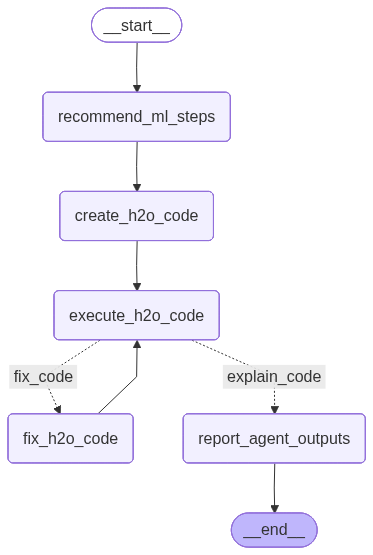

In [23]:
# 3.0 AGENT INITIALIZATION
# The agent will use Groq to "think" and H2O to "execute" models
ml_agent = H2OMLAgent(
    model=llm,
    log=True,
    log_path=LOG_PATH,
    model_directory=MODEL_PATH,
    enable_mlflow=True,
)

ml_agent

In [24]:
help(ml_agent.invoke_agent)

Help on method invoke_agent in module ai_data_science_team.ml_agents.h2o_ml_agent:

invoke_agent(data_raw: pandas.core.frame.DataFrame, user_instructions: str = None, target_variable: str = None, max_retries=3, retry_count=0, **kwargs) method of ai_data_science_team.ml_agents.h2o_ml_agent.H2OMLAgent instance
    Synchronously trains an H2O AutoML model for the provided dataset,
    saving the best model to disk if model_directory or log_path is available.



In [ ]:
max_runtime_secs = 3600 
max_retries = 10
max_models = 100

with open("prompt.txt", "r") as f:
    instructions_template = f.read()

instructions = instructions_template.replace("{max_runtime_secs}", str(max_runtime_secs))

technical_constraints = f"""
---
CRITICAL TECHNICAL RULES:
1. FORBIDDEN METHODS: Do not use h2o.cluster().is_running(). H2O will fail.
2. SIMPLICITY: Just call h2o.init() and then h2o.H2OFrame(pd.DataFrame(data_raw)).
3. PANDAS: Only use pandas for the initial conversion. After that, use H2O methods ONLY.
4. Use max_models={max_models} in the function h2o_automl
5. This is a regression task for time series forecasting (index of 'df' is a datetime with frequency 1 day)
---
"""

full_instructions = instructions + technical_constraints

print(f"🚀 Session started ({max_runtime_secs}s, {max_retries} retries)...")

ml_agent.invoke_agent(
    data_raw=df_selected,
    user_instructions=full_instructions,
    target_variable="y_mfe_log",
    max_retries=max_retries
)

🚀 Session started (3600s, 10 retries)...
---H2O ML AGENT----
    * RECOMMEND MACHINE LEARNING STEPS
    * CREATE H2O AUTOML CODE
      File saved to: c:\Users\Alessandro\Desktop\Cartelle\Mie\Programmi personali in Python\Forecasting BTC with ai-data-science-team\btc_forecast/ai_logs/h2o_automl.py
    * EXECUTING AGENT CODE
Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 mins 33 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,1 month and 17 days
H2O_cluster_name:,H2O_from_python_Alessandro_8gom4l
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.296 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█

In [8]:
# 5.0 RESULTS AND LOGS
print("\n--- MODEL LEADERBOARD ---")
print(ml_agent.get_leaderboard())

print("\n--- WORKFLOW SUMMARY ---")
print(ml_agent.get_workflow_summary(markdown=True))

# --- MODEL LEADERBOARD ---
#                                              model_id       rmse          mse  \
# 0        GBM_grid_1_AutoML_5_20260109_131652_model_22   0.029815     0.000889   
# 1        GBM_grid_1_AutoML_5_20260109_131652_model_23   0.029865     0.000892   
# 2         GBM_grid_1_AutoML_5_20260109_131652_model_1   0.030281     0.000917   
# 3         GBM_grid_1_AutoML_5_20260109_131652_model_3   0.030612     0.000937   
# 4        GBM_grid_1_AutoML_5_20260109_131652_model_10   0.030694     0.000942   
# 5         GBM_grid_1_AutoML_5_20260109_131652_model_9   0.030781     0.000947   
# 6                      GBM_4_AutoML_5_20260109_131652   0.030862     0.000952   
# 7        GBM_grid_1_AutoML_5_20260109_131652_model_52   0.030903     0.000955   
# 8         GBM_grid_1_AutoML_5_20260109_131652_model_8   0.031132     0.000969   
# 9        GBM_grid_1_AutoML_5_20260109_131652_model_55   0.031199     0.000973   
# 10       GBM_grid_1_AutoML_5_20260109_131652_model_57   0.031265     0.000977   
# 11                     XRT_1_AutoML_5_20260109_131652   0.031275     0.000978   
# 12       GBM_grid_1_AutoML_5_20260109_131652_model_50   0.031306     0.000980   
# 13       GBM_grid_1_AutoML_5_20260109_131652_model_59   0.031317     0.000981   
# 14                     GBM_3_AutoML_5_20260109_131652   0.031463     0.000990   
# 15       GBM_grid_1_AutoML_5_20260109_131652_model_47   0.031495     0.000992   
# 16       GBM_grid_1_AutoML_5_20260109_131652_model_56   0.031580     0.000997   
# 17                     GBM_2_AutoML_5_20260109_131652   0.031637     0.001001   
# 18        GBM_grid_1_AutoML_5_20260109_131652_model_2   0.031746     0.001008   
# 19       GBM_grid_1_AutoML_5_20260109_131652_model_13   0.031797     0.001011   
# 20        GBM_grid_1_AutoML_5_20260109_131652_model_7   0.031825     0.001013   
# 21       GBM_grid_1_AutoML_5_20260109_131652_model_60   0.032084     0.001029   
# 22                     DRF_1_AutoML_5_20260109_131652   0.032090     0.001030   
# 23       GBM_grid_1_AutoML_5_20260109_131652_model_61   0.032094     0.001030   
# 24       GBM_grid_1_AutoML_5_20260109_131652_model_21   0.032434     0.001052   
# 25       GBM_grid_1_AutoML_5_20260109_131652_model_62   0.032551     0.001060   
# 26       GBM_grid_1_AutoML_5_20260109_131652_model_48   0.032612     0.001064   
# 27       GBM_grid_1_AutoML_5_20260109_131652_model_15   0.032627     0.001064   
# 28  StackedEnsemble_AllModels_1_AutoML_5_20260109_...   0.033136     0.001098   
# 29       GBM_grid_1_AutoML_5_20260109_131652_model_18   0.033532     0.001124   
# 30       GBM_grid_1_AutoML_5_20260109_131652_model_12   0.033635     0.001131   
# 31  StackedEnsemble_BestOfFamily_1_AutoML_5_202601...   0.034021     0.001157   
# 32       GBM_grid_1_AutoML_5_20260109_131652_model_17   0.034049     0.001159   
# 33                     GBM_5_AutoML_5_20260109_131652   0.038438     0.001477   
# 34                     GLM_1_AutoML_5_20260109_131652  40.394677  1631.729912   

#           mae     rmsle  mean_residual_deviance  
# 0    0.020356  0.029052                0.000889  
# 1    0.021192  0.029128                0.000892  
# 2    0.020411  0.029519                0.000917  
# 3    0.021209  0.029878                0.000937  
# 4    0.021590  0.029958                0.000942  
# 5    0.020969  0.030029                0.000947  
# 6    0.021853  0.030122                0.000952  
# 7    0.021652  0.030145                0.000955  
# 8    0.022509  0.030394                0.000969  
# 9    0.021779  0.030457                0.000973  
# 10   0.023021  0.030528                0.000977  
# 11   0.022768  0.030558                0.000978  
# 12   0.022188  0.030568                0.000980  
# 13   0.022282  0.030574                0.000981  
# 14   0.022531  0.030731                0.000990  
# 15   0.023511  0.030767                0.000992  
# 16   0.023008  0.030851                0.000997  
# 17   0.022426  0.030898                0.001001  
# 18   0.023022  0.030985                0.001008  
# 19   0.022451  0.031055                0.001011  
# 20   0.023233  0.031071                0.001013  
# 21   0.021836  0.031379                0.001029  
# 22   0.023591  0.031350                0.001030  
# 23   0.023768  0.031345                0.001030  
# 24   0.022633  0.031691                0.001052  
# 25   0.023471  0.031838                0.001060  
# 26   0.023465  0.031831                0.001064  
# 27   0.023402  0.031892                0.001064  
# 28   0.025348  0.032389                0.001098  
# 29   0.024182  0.032760                0.001124  
# 30   0.024649  0.032832                0.001131  
# 31   0.025467  0.033237                0.001157  
# 32   0.024614  0.033333                0.001159  
# 33   0.028244  0.037562                0.001477  
# 34  11.764675       NaN             1631.729912  

# --- WORKFLOW SUMMARY ---
# <IPython.core.display.Markdown object>


--- MODEL LEADERBOARD ---
                                              model_id      rmse       mse  \
0         GBM_grid_1_AutoML_4_20260109_201711_model_73  0.037518  0.001408   
1    StackedEnsemble_BestOfFamily_1_AutoML_4_202601...  0.037627  0.001416   
2    StackedEnsemble_AllModels_1_AutoML_4_20260109_...  0.037633  0.001416   
3         GBM_grid_1_AutoML_4_20260109_201711_model_65  0.037643  0.001417   
4         GBM_grid_1_AutoML_4_20260109_201711_model_13  0.037652  0.001418   
..                                                 ...       ...       ...   
118       GBM_grid_1_AutoML_4_20260109_201711_model_54  0.040040  0.001603   
119      GBM_grid_1_AutoML_4_20260109_201711_model_100  0.040182  0.001615   
120      GBM_grid_1_AutoML_4_20260109_201711_model_108  0.040713  0.001658   
121       GBM_grid_1_AutoML_4_20260109_201711_model_35  0.040719  0.001658   
122                     GLM_1_AutoML_4_20260109_201711  0.227273  0.051653   

          mae     rmsle  mean_residu

In [9]:
# 6.0 LOADING THE WINNING MODEL (H2O)
h2o.init()
model_path = ml_agent.get_model_path()
best_model = h2o.load_model(model_path)

print("\n✅ Best Model Loaded. Performance:")
print(best_model.model_performance())

# ✅ Best Model Loaded. Performance:
# ModelMetricsRegression: gbm
# ** Reported on train data. **

# MSE: 0.0004360875665033196
# RMSE: 0.020882709750013755
# MAE: 0.013057986199523188
# RMSLE: 0.020127607882830027
# Mean Residual Deviance: 0.0004360875665033196

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,48 mins 51 secs
H2O_cluster_timezone:,Europe/Berlin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,1 month and 16 days
H2O_cluster_name:,H2O_from_python_Alessandro_9lrdox
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.041 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"



✅ Best Model Loaded. Performance:
ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 0.0010634963466632703
RMSE: 0.032611291704918256
MAE: 0.025545788360597902
RMSLE: 0.033041833480539566
Mean Residual Deviance: 0.0010634963466632703


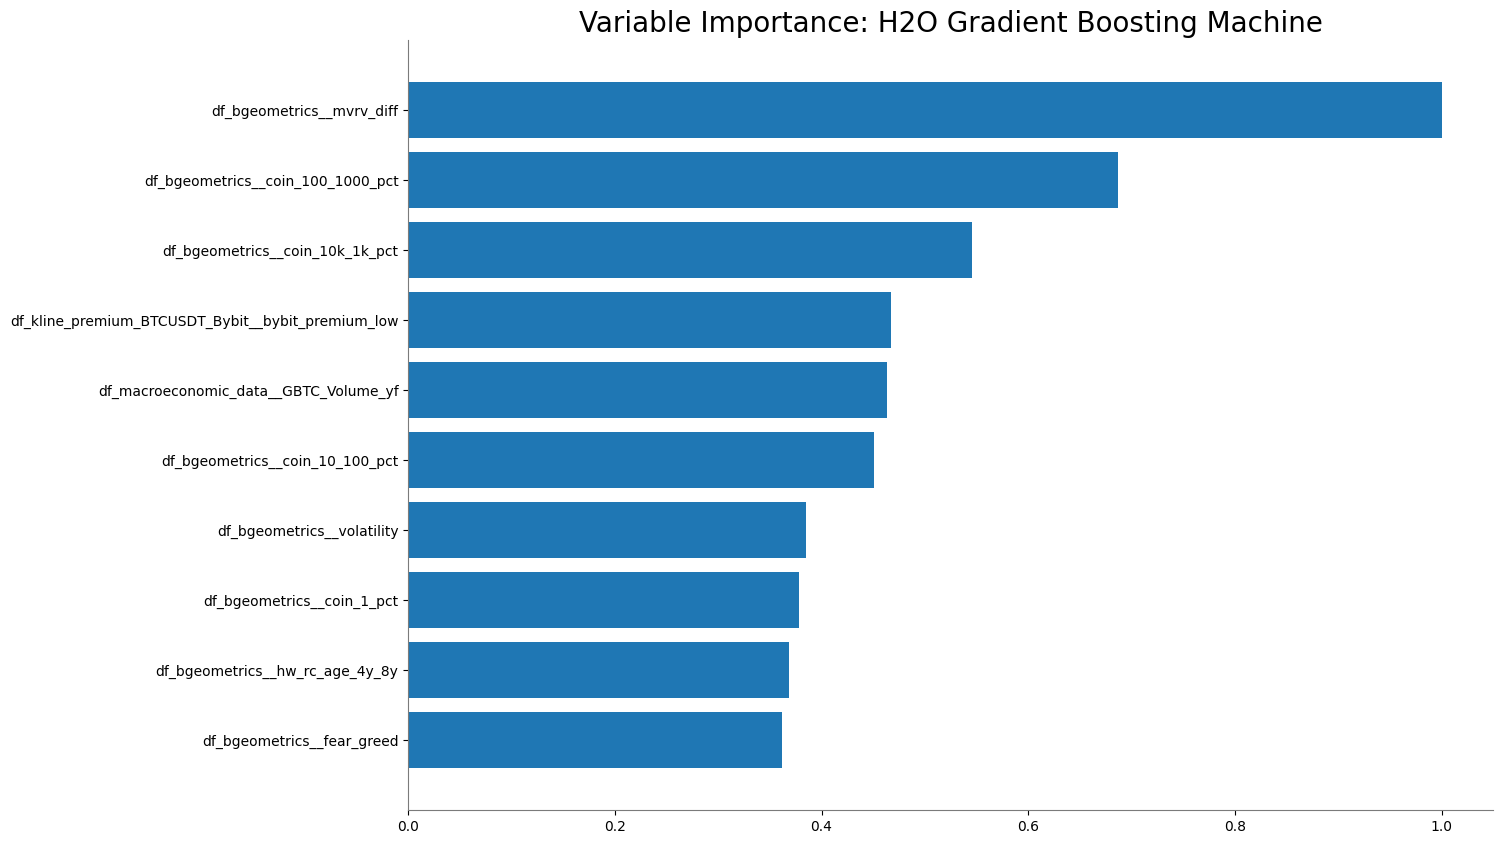

<Figure size 640x480 with 0 Axes>

In [10]:
# Look at which variables are most important
best_model.varimp_plot()

In [ ]:
best_model.varimp(True)

### Re-training with the best features

In [ ]:
ml_agent_2 = H2OMLAgent(
    model=llm,
    log=True,
    log_path=LOG_PATH_RETRAINING,
    model_directory=MODEL_PATH_RETRAINING,
    enable_mlflow=True,
)

In [ ]:
# 1. Retrieve variable importance in table format
var_imp = best_model.varimp(True)

# 2. Select variables whose cumulative importance reaches a certain threshold
threshold = 0.99
var_imp['cum_importance'] = var_imp['percentage'].cumsum()
top_features = var_imp[var_imp['cum_importance'].shift(1, fill_value=0) < threshold]['variable'].tolist()
top_n = len(top_features)

print(f"✅ Selected the {top_n} most important features:")
print(top_features)

# 3. Create a new reduced dataframe (+ target column)
df_reduced = df[top_features + ["y_mfe_log"]]
df_reduced.to_csv(DATA_REDUCED_PATH)

# 4. Relaunch the agent only on these
# This new model will only require these inputs for inference
ml_agent_2.invoke_agent(
    data_raw=df_reduced,
    user_instructions=full_instructions,
    target_variable="y_mfe_log",
    max_retries=max_retries
)

In [ ]:
print("\n--- MODEL LEADERBOARD ---")
print(ml_agent_2.get_leaderboard())

print("\n--- WORKFLOW SUMMARY ---")
print(ml_agent_2.get_workflow_summary(markdown=True))

In [ ]:
h2o.init()
model_path_2 = ml_agent_2.get_model_path()
best_model_2 = h2o.load_model(model_path_2)

print("\n✅ Best Model Loaded. Performance:")
print(best_model_2.model_performance())

In [ ]:
best_model_2.varimp_plot()

### Inference

In [11]:
import h2o
import pandas as pd
import os

In [ ]:
# --- PATH CONFIGURATION (Fallback) ---
# Use the same paths defined at the beginning of the notebook
MODEL_DIR_INF = r"btc_forecast/h2o_models_retraining/"
DATA_PATH_INF = "data/all_together/dataset_X_and_y_mfe_log.csv"

# 1. H2O Initialization
try:
    # Check if H2O is already active
    h2o.connection()
    print("✅ H2O is already initialized.")
except:
    print("🔄 Initializing H2O...")
    h2o.init()

✅ H2O is already initialized.


In [ ]:
# 2. Model Loading
# Try to use 'ml_agent_2' if present, otherwise look for the model in the directory
if 'ml_agent_2' in globals() and ml_agent_2.get_model_path():
    print("✅ Retrieving model from active agent...")
    model_path_inf = ml_agent_2.get_model_path()
    best_model_inf = h2o.load_model(model_path_inf)
else:
    print("📂 Clean session: Loading the last model saved on disk...")
    # Look for the most recent file in the models directory
    model_files = [os.path.join(MODEL_DIR_INF, f) for f in os.listdir(MODEL_DIR_INF) if not f.endswith('.json')]
    if not model_files:
        raise FileNotFoundError(f"No model found in {MODEL_DIR_INF}")
    latest_model = max(model_files, key=os.path.getmtime)
    print(f"📄 Loading model: {latest_model}")
    best_model_inf = h2o.load_model(latest_model)

✅ Retrieving model from active agent...


In [ ]:
# 3. DataFrame Management (Schema and Features)
# If 'df_reduced' does not exist (session restarted), reload the dataset and apply minimal cleaning
if 'df_reduced' not in globals():
    print("📊 DataFrame not found. Reloading and cleaning data to obtain the schema...")
    df_reduced = pd.read_csv(DATA_REDUCED_PATH)
    # Apply the same cleaning as in point 2.0 of the notebook
    df_reduced = df_reduced.replace([float('inf'), float('-inf')], pd.NA)
    df_reduced = df_reduced.dropna(thresh=len(df_reduced) * 0.5, axis=1) # Remove columns with >50% NaN
    df_reduced = df_reduced.loc[:, (df_reduced != df_reduced.iloc[0]).any()]      # Remove constant columns
    df_reduced = df_reduced.apply(pd.to_numeric, errors='coerce').dropna()
else:
    print("✅ DataFrame 'df_reduced' already present in memory.")

# Identify features (excluding the target)
train_features = [c for c in df_reduced.columns if c != "y_mfe_log"]

# --- INFERENCE EXAMPLE ---
# Use the last row of the dataset as a placeholder for testing
df_input = df_reduced.iloc[[-1]][train_features]
h2o_input = h2o.H2OFrame(df_input)

prediction = best_model_inf.predict(h2o_input)
print("\n" + "="*40)
print(f"🎰 INFERENCE RESULT")
print(f"Model ID: {best_model_inf.model_id}")
print(f"Target prediction (log-return): {prediction[0, 0]:.6f}")
print(f'Target prediction (price variation): {np.exp(prediction[0, 0]):.6f}')
print("="*40)

✅ DataFrame 'df' already present in memory.
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

🎰 INFERENCE RESULT
Model ID: GBM_grid_1_AutoML_4_20260109_201711_model_73
Target prediction (log-return): -0.007729


In [40]:
ohlcv_1m.loc[df.iloc[[-1]].index]["close_bybit_futures"].iloc[0]

np.float64(93210.0)

In [47]:
print(f'Target prediction (price): {ohlcv_1m.loc[df.iloc[[-1]].index]["close_bybit_futures"].iloc[0] * np.exp(prediction[0, 0]):.2f}')

Target prediction (price): 92492.32
